# Fudan RPML Assignment1: Machine Learning Meets Fashion

![Machine Learning Meets Fashion](./img/ml_meets_fashion.jpg)

*Your name and Student ID: [张钰轩], [20307140021]*

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this assignment, you will use what you have learned to tackle some pratical problems. Fashion MNIST dataset[1] is the MNIST-like fashion product database for image classification you will play with this time. It originally consists of a training set of 60000 examples and a test set of 10000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

To make this task more realistic, we selected 14600 labeled examples from the training set and did a little processing. You have to do this image classifictaion task with our new dataset. 

You have to impletement several standard classification methods in the './fudanPRML' folder:
- K-nearest Neighbor (15 points)
- Softmax (15 points)
- Neural Network (30 points)    

and then do your exploration (30 points).

You can only use some basic python libraries in your experiment like numpy, paddle(without using the paddle.nn), matplotlib and so on. And please write down the version with them in the './requirements.txt' file.

## 1. Setup

In [1]:
# setup code
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')

In [3]:
label_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

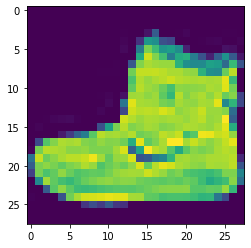

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(X_train[0].reshape(28,28))

## 2. Exploratory Data Analysis (5 points)

Your may have to explore the dataset and do some analysis first.

In [5]:

import torch


print ("训练集样本形状：", X_train.shape)
print ("训练集标签形状：", y_train.shape)
print ("测试集样本形状：", X_test.shape)
print ("测试集标签形状：", y_test.shape)
print ("测试集标签类型：", X_test.dtype)
print ("训练集标签类型：", X_train.dtype)
X_train=torch.from_numpy(X_train).float()
X_test=torch.from_numpy(X_test).float()
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)
print ("转换后测试集标签类型：", X_test.dtype)
print ("转换后训练集标签类型：", X_train.dtype)

训练集样本形状： (14600, 784)
训练集标签形状： (14600,)
测试集样本形状： (10000, 784)
测试集标签形状： (10000,)
测试集标签类型： uint8
训练集标签类型： uint8
转换后测试集标签类型： torch.float32
转换后训练集标签类型： torch.float32


## 3. Methodology

In [6]:
# Please open the corresponding file and complete it first
# The codebase is organized in a sklearn style
# you have to finish the 'fit' and 'predict' function and do your experiment in this .ipynb file
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
from fudanPRML.linear_model.softmax import SoftmaxClassifier
from fudanPRML.neural_network.mlp import MLPClassifier
device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:1


### K-nearest Neighbor (15 points)

In [7]:

clf = KNearestNeighbor()
X_train=X_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
y_train=y_train.to(device)
clf.fit(X_train, y_train)

#计算距离矩阵
dists = clf.compute_distances_no_loops(X_test)
print(dists.shape)


torch.Size([10000, 14600])


In [8]:
# 现在实现函数predict_labels并运行以下代码：
# 我们使用k = 1（这是最近的邻居）。
y_test_pred = clf.predict_labels(dists, k=1)
y_test_pred=y_test_pred.to(device)
# 计算并打印出预测的精度
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

Got 7887 / 10000 correct => accuracy: 0.788700


In [9]:
# 我们接下来尝试更大的k值
y_test_pred = clf.predict_labels(dists, k=5)
y_test_pred=y_test_pred.to(device)
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

Got 7807 / 10000 correct => accuracy: 0.780700


In [10]:

##进行交叉验证

from pickletools import uint8


num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = torch.chunk(X_train,num_folds,dim=0)
y_train_folds = torch.chunk(y_train,num_folds,dim=0)

k_to_accuracies = {}


for i in range(0,num_folds):
    X_train_t=torch.zeros((1,X_train.shape[1]))
    y_train_t=torch.zeros(1).int()
    X_train_t=X_train_t.to(device)
    y_train_t=y_train_t.to(device)
    for j in range(0,num_folds):
        if j!=i:
            X_train_t=torch.cat((X_train_t,X_train_folds[j]),0,out=None)
            y_train_t=torch.cat((y_train_t,y_train_folds[j]),0,out=None)

    #将初始化的头部尾部删掉
    X_train_t= X_train_t[torch.arange(X_train_t.size(0))!=0]
    y_train_t= y_train_t[torch.arange(y_train_t.size(0))!=0]
        
    clf.fit(X_train_t,y_train_t)
    dists = clf.compute_distances_no_loops(X_train_folds[i])
    for k in k_choices:
        if i==0:
            k_to_accuracies[k]=[]
        y_test_pred = clf.predict_labels(dists, k=k)
        y_test_pred=y_test_pred.to(device)
        num_correct = torch.sum(y_test_pred == y_train_folds[i])
        accuracy = float(num_correct) / len(y_test_pred)
        k_to_accuracies[k].append(accuracy)
    

# 打印出计算的精度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.681849
k = 1, accuracy = 0.805822
k = 1, accuracy = 0.944863
k = 1, accuracy = 0.961644
k = 1, accuracy = 0.948288
k = 3, accuracy = 0.684247
k = 3, accuracy = 0.814041
k = 3, accuracy = 0.944178
k = 3, accuracy = 0.969178
k = 3, accuracy = 0.969521
k = 5, accuracy = 0.686644
k = 5, accuracy = 0.814041
k = 5, accuracy = 0.946233
k = 5, accuracy = 0.968151
k = 5, accuracy = 0.966781
k = 8, accuracy = 0.680137
k = 8, accuracy = 0.812329
k = 8, accuracy = 0.946233
k = 8, accuracy = 0.966781
k = 8, accuracy = 0.965753
k = 10, accuracy = 0.679110
k = 10, accuracy = 0.813699
k = 10, accuracy = 0.945205
k = 10, accuracy = 0.966096
k = 10, accuracy = 0.966781
k = 12, accuracy = 0.674658
k = 12, accuracy = 0.809932
k = 12, accuracy = 0.945548
k = 12, accuracy = 0.965753
k = 12, accuracy = 0.966096
k = 15, accuracy = 0.676027
k = 15, accuracy = 0.803425
k = 15, accuracy = 0.942466
k = 15, accuracy = 0.966096
k = 15, accuracy = 0.961986
k = 20, accuracy = 0.672603
k = 20, accu

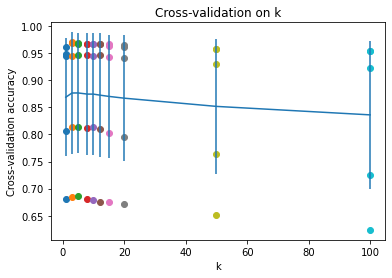

In [11]:

# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [12]:
best_k = k_choices[accuracies_mean.argmax()]

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test, k=best_k).to(device)

# Compute and display the accuracy
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))
print('best_k:',best_k)

Got 7807 / 10000 correct => accuracy: 0.780700
best_k: 5


### Softmax (15 points)

In [36]:
#数据初始化

import torch
import numpy as np
device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')
X_train=torch.from_numpy(X_train).to(torch.float64).to(device)
X_test=torch.from_numpy(X_test).to(torch.float64).to(device)
y_train=torch.from_numpy(y_train).to(device)
y_test=torch.from_numpy(y_test).to(device)
train_n=10000
X_dev=X_train[train_n:,]
y_dev=y_train[train_n:]
X_train=X_train[:train_n,:]
y_train=y_train[:train_n]


print ("转换后测试集标签类型：", X_test.dtype)
print ("转换后训练集标签类型：", X_train.dtype)

cuda:1
转换后测试集标签类型： torch.float64
转换后训练集标签类型： torch.float64


In [37]:
from fudanPRML.linear_model.softmax import SoftmaxClassifier

In [41]:
clf=SoftmaxClassifier(input_size=X_train.shape[1],output_size=10)
clf.predict(X_train,y_train,X_dev,y_dev,lr=0.000006,epochs=10000)

best accuracy performence has been updated: 0.00000 --> 0.95717
[Train] epoch: 0, loss: 3.3219280948873626, score: 0.26729997992515564
[Dev] epoch: 0, loss: 0.29424332367486306, score: 0.9571739435195923
best accuracy performence has been updated: 0.95717 --> 0.95739
best accuracy performence has been updated: 0.95739 --> 0.96478
[Train] epoch: 100, loss: 0.9691825565131301, score: 0.8337000012397766
[Dev] epoch: 100, loss: 0.5178623466048605, score: 0.8904348015785217
[Train] epoch: 200, loss: 0.7867172251265371, score: 0.8597999811172485
[Dev] epoch: 200, loss: 0.4676822665003118, score: 0.907608687877655
[Train] epoch: 300, loss: 0.7112267066603218, score: 0.8684999942779541
[Dev] epoch: 300, loss: 0.43538074780815655, score: 0.9143478274345398
[Train] epoch: 400, loss: 0.6694911318330862, score: 0.8741999864578247
[Dev] epoch: 400, loss: 0.4179726826089154, score: 0.9184783101081848
[Train] epoch: 500, loss: 0.641613930737932, score: 0.8782999515533447
[Dev] epoch: 500, loss: 0.407

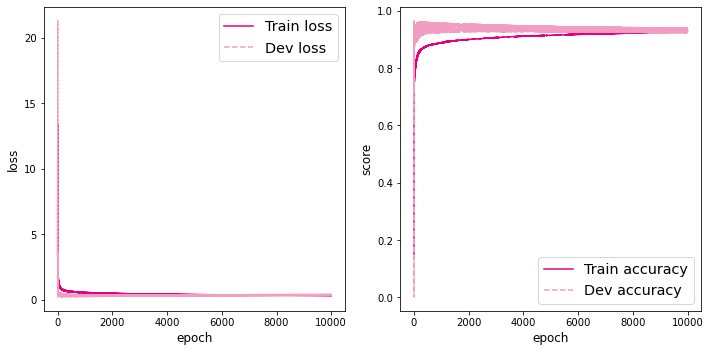

[Test] score/loss: 0.7619/1.2039


In [42]:
#进行可视化
clf.plt()
score, loss = clf.evaluate([X_test,y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

### Neural Network (30 points)

In [1]:
#数据初始化

import torch
import numpy as np
device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')
X_train=torch.from_numpy(X_train).to(device).to(torch.float64)
X_test=torch.from_numpy(X_test).to(device).to(torch.float64)
y_train=torch.from_numpy(y_train).to(device)
y_test=torch.from_numpy(y_test).to(device)
train_n=10000
X_dev=X_train[train_n:,]
y_dev=y_train[train_n:]
X_train=X_train[:train_n,:]
y_train=y_train[:train_n]


print ("转换后测试集标签类型：", X_test.dtype)
print ("转换后训练集标签类型：", X_train.dtype)

cuda:1
转换后测试集标签类型： torch.float64
转换后训练集标签类型： torch.float64


In [2]:
from fudanPRML.neural_network.mlp import MLPClassifier

In [26]:
ep=15000 #训练次数
learning_rating=0.0000876
clf=MLPClassifier(input_size=X_train.shape[1],hide_size=100,output_size=10)
clf.predict(X_train, y_train,X_dev, y_dev,lr=learning_rating,epoch_num=ep)

[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.34346
[Train] epoch: 0, loss: 20.36556776256067, score: 0.06583333015441895
[Dev] epoch: 0, loss: 11.878017734593456, score: 0.3434615433216095
[Evaluate] best accuracy performence has been updated: 0.34346 --> 0.43423
[Evaluate] best accuracy performence has been updated: 0.43423 --> 0.43846
[Evaluate] best accuracy performence has been updated: 0.43846 --> 0.52923
[Evaluate] best accuracy performence has been updated: 0.52923 --> 0.66808
[Evaluate] best accuracy performence has been updated: 0.66808 --> 0.68385
[Evaluate] best accuracy performence has been updated: 0.68385 --> 0.70538
[Evaluate] best accuracy performence has been updated: 0.70538 --> 0.73231
[Evaluate] best accuracy performence has been updated: 0.73231 --> 0.74308
[Evaluate] best accuracy performence has been updated: 0.74308 --> 0.74385
[Evaluate] best accuracy performence has been updated: 0.74385 --> 0.75462
[Evaluate] best accuracy performence 

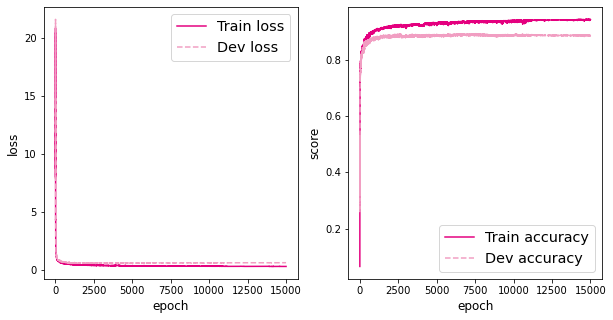

[Test] score/loss: 0.7069/1.6530


In [27]:
clf.plt()
score, loss = clf.evaluate([X_test,y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

### Your Exploration (30 points)

In [1]:
#将数据进行打乱后划分训练集与验证集
import torch
import numpy as np
device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')
#将验证集打乱
Xtr=np.hstack((X_train,y_train.reshape(-1,1)))
Xte=np.hstack((X_test,y_test.reshape(-1,1)))
print(Xtr.shape,Xte.shape)
np.random.shuffle(Xtr)  
np.random.shuffle(Xte) 
Xtr=torch.from_numpy(Xtr).to(device)
Xte=torch.from_numpy(Xte).to(device)
X_train=Xtr[:,:Xtr.shape[1]-1].to(torch.float64)
y_train=Xtr[:,Xtr.shape[1]-1]
X_test=Xte[:,:Xte.shape[1]-1].to(torch.float64)
y_test=Xte[:,Xte.shape[1]-1]
X=X_train
y=y_train
print(X.shape,y.shape)
#划分训练集与验证集
train_n=10000
X_dev=X_train[train_n:,]
y_dev=y_train[train_n:]
X_train=X_train[:train_n,:]
y_train=y_train[:train_n]

cuda:1
(14600, 785) (10000, 785)
torch.Size([14600, 784]) torch.Size([14600])


In [5]:
#统计训练集和测试集不同种类的数目
y_testmat=torch.nn.functional.one_hot(y_test.long())
y_testsum=torch.sum(y_testmat,dim=0).to("cpu").numpy()
y_trainmat=torch.nn.functional.one_hot(y.long())
y_trainsum=torch.sum(y_trainmat,dim=0).to("cpu").numpy()
print("训练集每种种类的数目:",y_trainsum)
print("测试集每种种类数目:",y_testsum)


训练集每种种类的数目: [6000 4000 1000 1000 1000 1000  200  200  100  100]
测试集每种种类数目: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [60]:
#进行knn分类
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
from pickletools import uint8
clf = KNearestNeighbor()
clf.fit(X, y)
#计算距离矩阵
dists = clf.compute_distances_no_loops(X_test)
print(dists.shape)

#进行交叉验证
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = torch.chunk(X,num_folds,dim=0)
y_train_folds = torch.chunk(y,num_folds,dim=0)

k_to_accuracies = {}


for i in range(0,num_folds):
    X_train_t=torch.zeros((1,X.shape[1]))
    y_train_t=torch.zeros(1).int()
    X_train_t=X_train_t.to(device)
    y_train_t=y_train_t.to(device)
    for j in range(0,num_folds):
        if j!=i:
            X_train_t=torch.cat((X_train_t,X_train_folds[j]),0,out=None)
            y_train_t=torch.cat((y_train_t,y_train_folds[j]),0,out=None)

    #将初始化的头部尾部删掉
    X_train_t= X_train_t[torch.arange(X_train_t.size(0))!=0]
    y_train_t= y_train_t[torch.arange(y_train_t.size(0))!=0]
        
    clf.fit(X_train_t,y_train_t)
    dists = clf.compute_distances_no_loops(X_train_folds[i])
    for k in k_choices:
        if i==0:
            k_to_accuracies[k]=[]
        y_test_pred = clf.predict_labels(dists, k=k)
        y_test_pred=y_test_pred.to(device)
        num_correct = torch.sum(y_test_pred == y_train_folds[i])
        accuracy = float(num_correct) / len(y_test_pred)
        k_to_accuracies[k].append(accuracy)
    

# 打印出计算的精度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

torch.Size([10000, 14600])
k = 1, accuracy = 0.911301
k = 1, accuracy = 0.899315
k = 1, accuracy = 0.904452
k = 1, accuracy = 0.897260
k = 1, accuracy = 0.907192
k = 3, accuracy = 0.916096
k = 3, accuracy = 0.912329
k = 3, accuracy = 0.905479
k = 3, accuracy = 0.907192
k = 3, accuracy = 0.913699
k = 5, accuracy = 0.916438
k = 5, accuracy = 0.914384
k = 5, accuracy = 0.909247
k = 5, accuracy = 0.904452
k = 5, accuracy = 0.917466
k = 8, accuracy = 0.918151
k = 8, accuracy = 0.910274
k = 8, accuracy = 0.909589
k = 8, accuracy = 0.898288
k = 8, accuracy = 0.916781
k = 10, accuracy = 0.917808
k = 10, accuracy = 0.909247
k = 10, accuracy = 0.907534
k = 10, accuracy = 0.895890
k = 10, accuracy = 0.916096
k = 12, accuracy = 0.916096
k = 12, accuracy = 0.906164
k = 12, accuracy = 0.907192
k = 12, accuracy = 0.897260
k = 12, accuracy = 0.914726
k = 15, accuracy = 0.910616
k = 15, accuracy = 0.906507
k = 15, accuracy = 0.903425
k = 15, accuracy = 0.895205
k = 15, accuracy = 0.914384
k = 20, accur

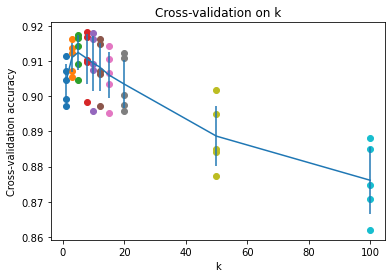

In [61]:
from matplotlib import pyplot as plt
# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

best_k = k_choices[accuracies_mean.argmax()]

clf.fit(X, y)
y_test_pred = clf.predict(X_test, k=best_k).to(device)


In [62]:
# 计算准确率
y_predright=np.zeros(shape=(10),dtype=int)
for i in range(y_test.shape[0]):
    if y_test_pred[i]==y_test[i]:
        y_predright[y_test[i]]+=1
print("预测每种种类正确的数目:",y_predright)
print("测试集每种种类数目:",y_testsum)
num_correct = torch.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))
print('best_k:',best_k)

预测每种种类正确的数目: [977 967 790 731 749 907 158 918 732 878]
测试集每种种类数目: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       device='cuda:1')
Got 7807 / 10000 correct => accuracy: 0.780700
best_k: 5


best accuracy performence has been updated: 0.00000 --> 0.40652
[Train] epoch: 0, loss: 3.3219280948873626, score: 0.4129999876022339
[Dev] epoch: 0, loss: 8.681029156451588, score: 0.406521737575531
best accuracy performence has been updated: 0.40652 --> 0.69043
best accuracy performence has been updated: 0.69043 --> 0.70065
best accuracy performence has been updated: 0.70065 --> 0.76478
best accuracy performence has been updated: 0.76478 --> 0.76891
best accuracy performence has been updated: 0.76891 --> 0.77478
best accuracy performence has been updated: 0.77478 --> 0.80652
best accuracy performence has been updated: 0.80652 --> 0.82152
best accuracy performence has been updated: 0.82152 --> 0.82478
best accuracy performence has been updated: 0.82478 --> 0.82630
best accuracy performence has been updated: 0.82630 --> 0.82761
best accuracy performence has been updated: 0.82761 --> 0.82913
best accuracy performence has been updated: 0.82913 --> 0.83065
best accuracy performence has be

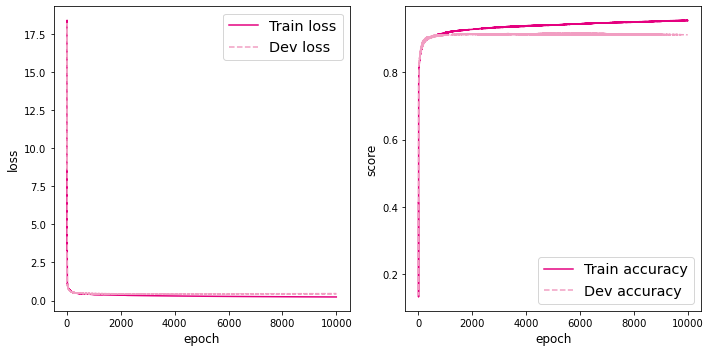

In [56]:
#进行softmax分类
from fudanPRML.linear_model.softmax import SoftmaxClassifier
clf=SoftmaxClassifier(input_size=X_train.shape[1],output_size=10)
clf.predict(X_train,y_train,X_dev,y_dev,lr=0.000006,epochs=10000)
clf.plt()

In [57]:
score, loss = clf.evaluate([X_test,y_test])
y_pred=clf.runner.logits
y_pred=torch.argmax(y_pred,dim=1)
y_predright=np.zeros(shape=(10),dtype=int)
for i in range(y_test.shape[0]):
    if y_pred[i]==y_test[i]:
        y_predright[y_test[i]]+=1
print("预测每种种类正确的数目:",y_predright)
print("测试集每种种类数目:",y_testsum)
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

预测每种种类正确的数目: [950 966 792 767 746 925 171 822 646 834]
测试集每种种类数目: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
[Test] score/loss: 0.7619/1.2207


[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.41457
[Train] epoch: 0, loss: 18.339444551410313, score: 0.03949999809265137
[Dev] epoch: 0, loss: 13.246154770447, score: 0.41456523537635803
[Evaluate] best accuracy performence has been updated: 0.41457 --> 0.42826
[Evaluate] best accuracy performence has been updated: 0.42826 --> 0.44870
[Evaluate] best accuracy performence has been updated: 0.44870 --> 0.66022
[Evaluate] best accuracy performence has been updated: 0.66022 --> 0.67674
[Evaluate] best accuracy performence has been updated: 0.67674 --> 0.70500
[Evaluate] best accuracy performence has been updated: 0.70500 --> 0.71435
[Evaluate] best accuracy performence has been updated: 0.71435 --> 0.72326
[Evaluate] best accuracy performence has been updated: 0.72326 --> 0.73261
[Evaluate] best accuracy performence has been updated: 0.73261 --> 0.74283
[Evaluate] best accuracy performence has been updated: 0.74283 --> 0.75152
[Evaluate] best accuracy performence h

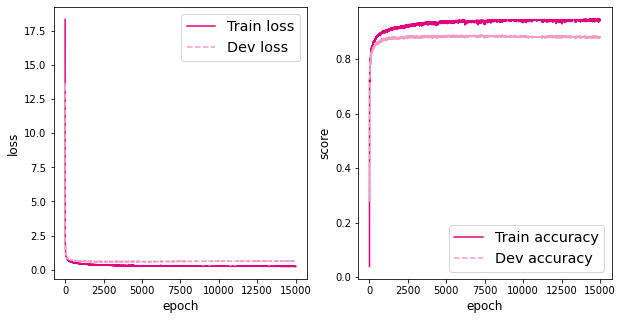

In [3]:
from fudanPRML.neural_network.mlp import MLPClassifier
ep=15000 #训练次数
learning_rating=0.0000876
clf=MLPClassifier(input_size=X_train.shape[1],hide_size=100,output_size=10)
clf.predict(X_train, y_train,X_dev, y_dev,lr=learning_rating,epoch_num=ep)
clf.plt()

In [6]:
score, loss = clf.evaluate([X_test,y_test])
y_pred=clf.runner.logits
y_pred=torch.argmax(y_pred,dim=1)
y_predright=np.zeros(shape=(10),dtype=int)
for i in range(y_test.shape[0]):
    if y_pred[i]==y_test[i]:
        y_predright[y_test[i]]+=1
print("预测每种种类正确的数目:",y_predright)
print("测试集每种种类数目:",y_testsum)
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

预测每种种类正确的数目: [942 956 711 691 729 892 114 744 473 691]
测试集每种种类数目: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
[Test] score/loss: 0.6943/1.7721


In [8]:
#将数据点降维处理，查看一下数据的分布情况
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
dataset_path = './dataset'

X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')
#pca = PCA(n_components=100)
tsne=TSNE(n_components=2)
#newXtr=pca.fit_transform(X_train)
#print(sum(pca.explained_variance_ratio_))
newXtr=tsne.fit_transform(X_train)
#newXte=pca.fit_transform(X_test)
newXte=tsne.fit_transform(X_test)
print(newXtr.shape)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


(14600, 2)


In [9]:
def plot(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    #进行归一化
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure(figsize=(50, 50))

    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

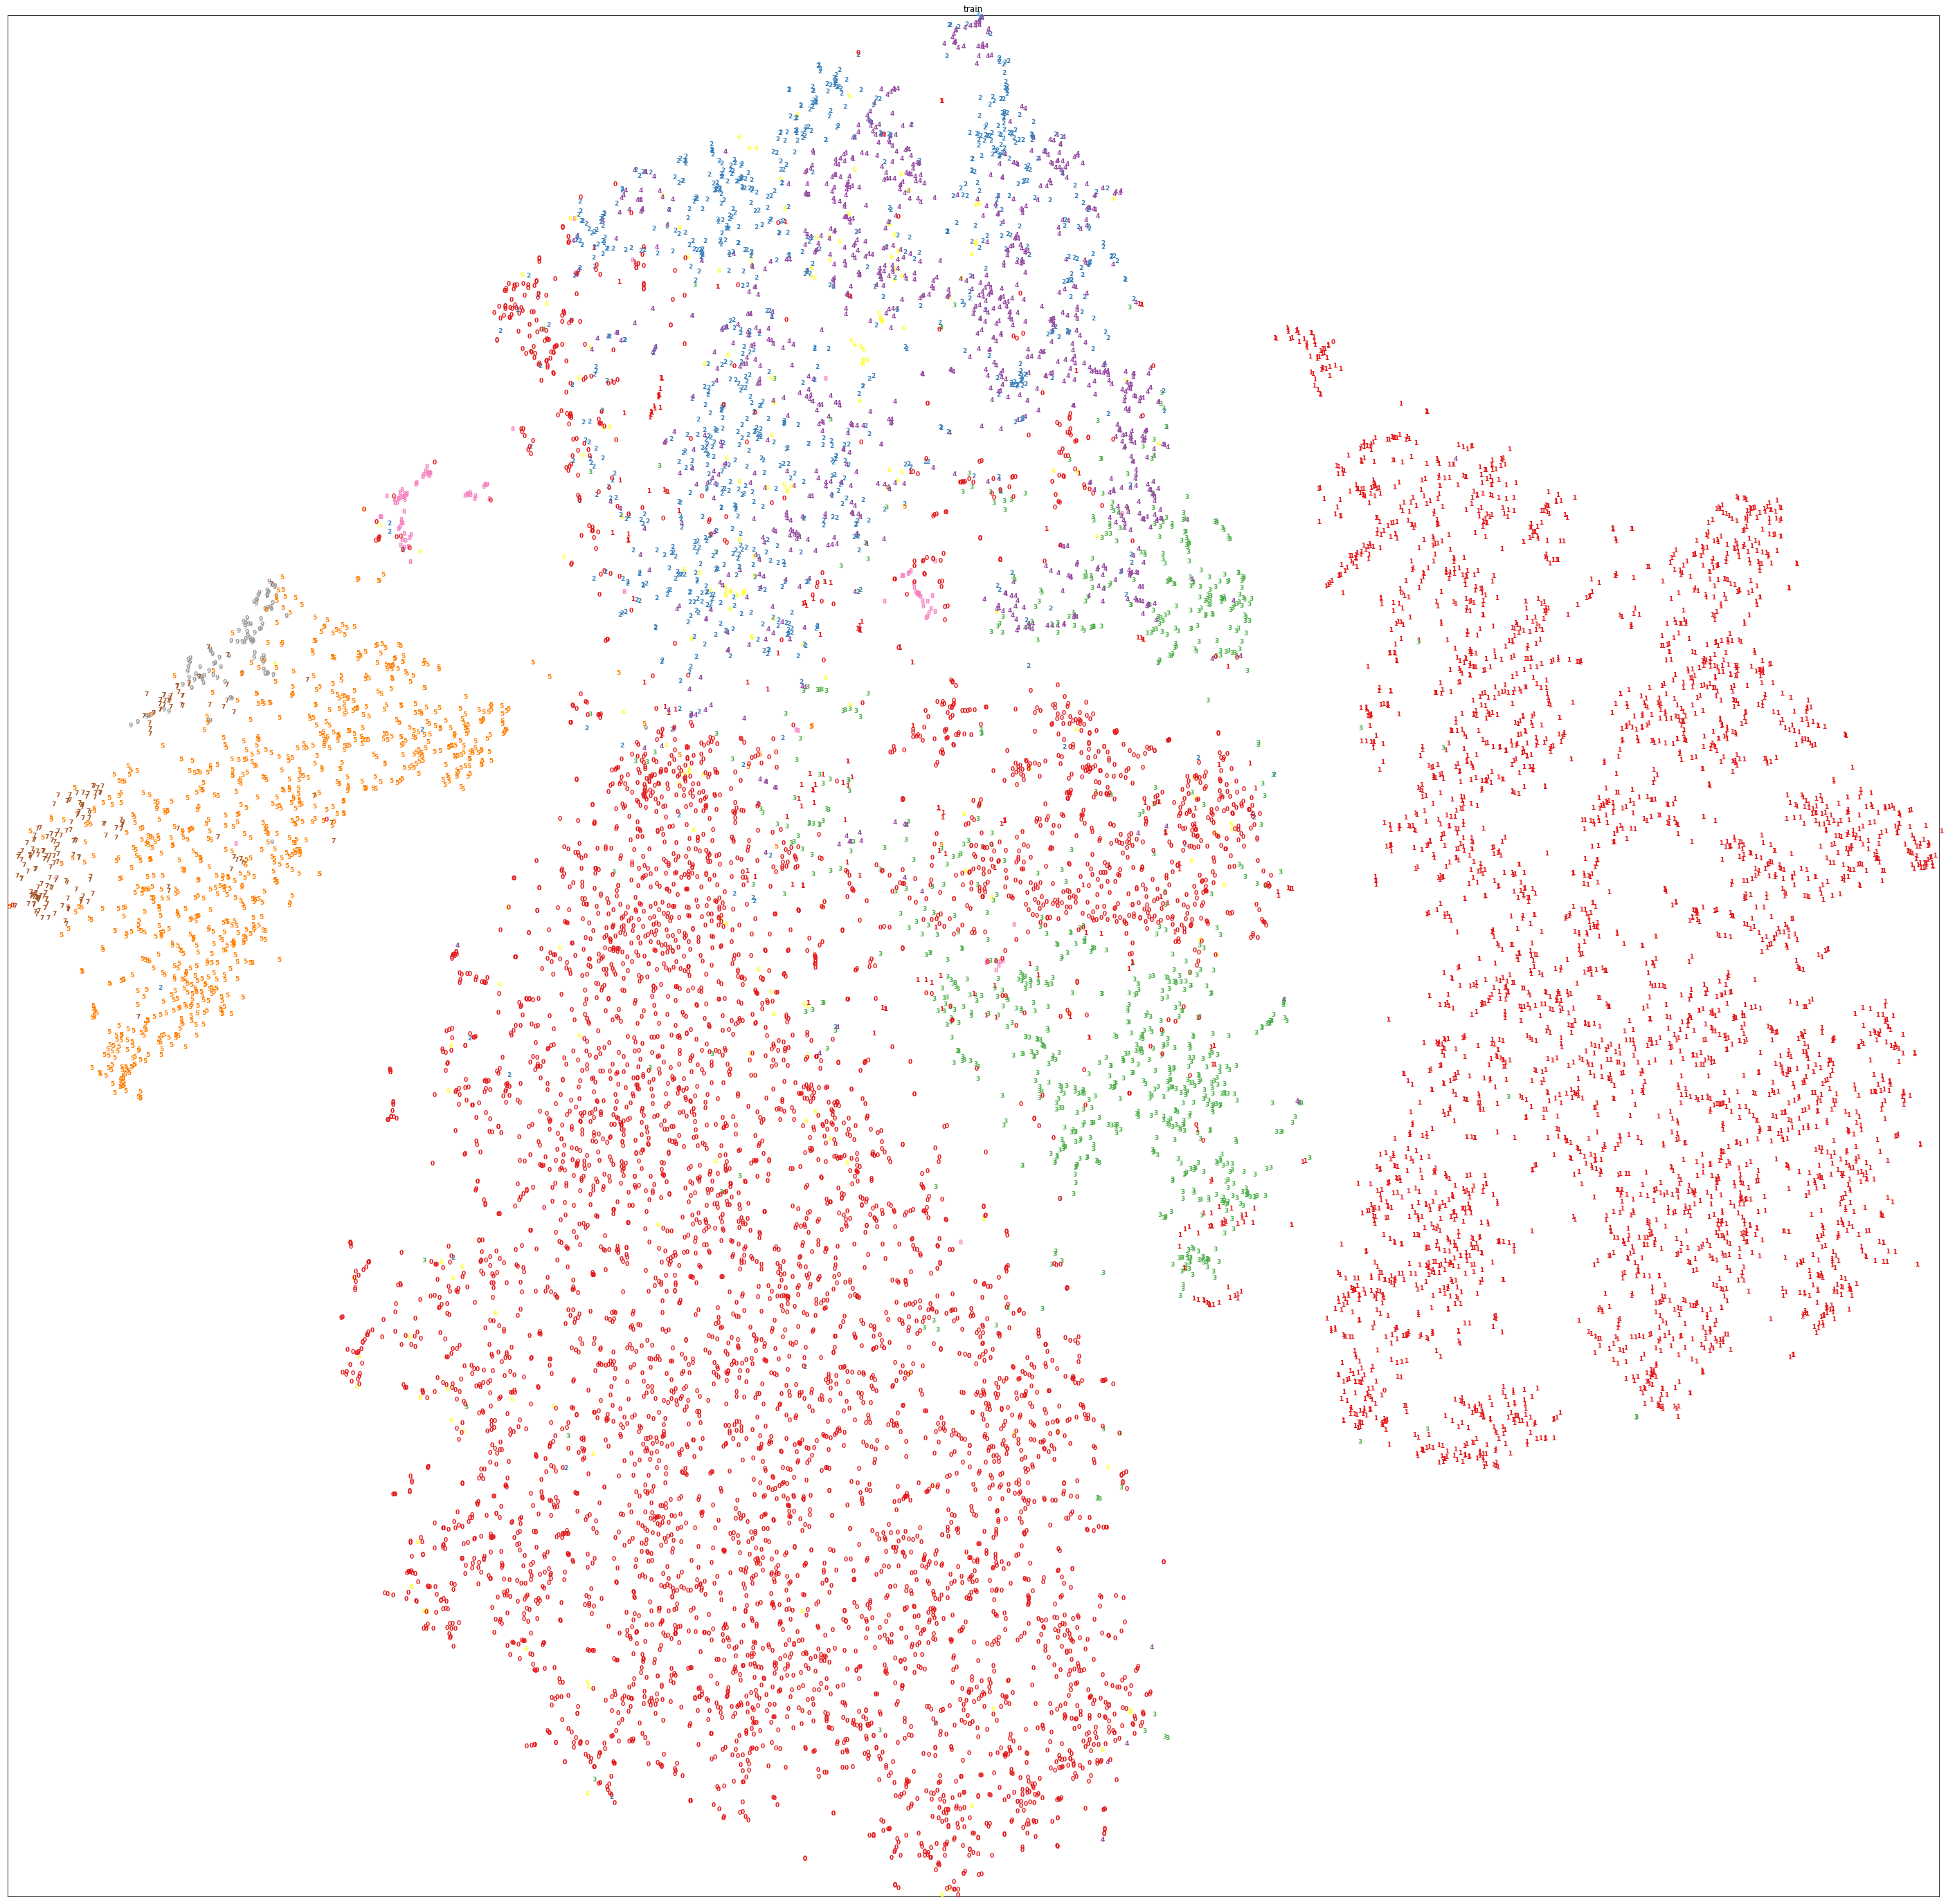

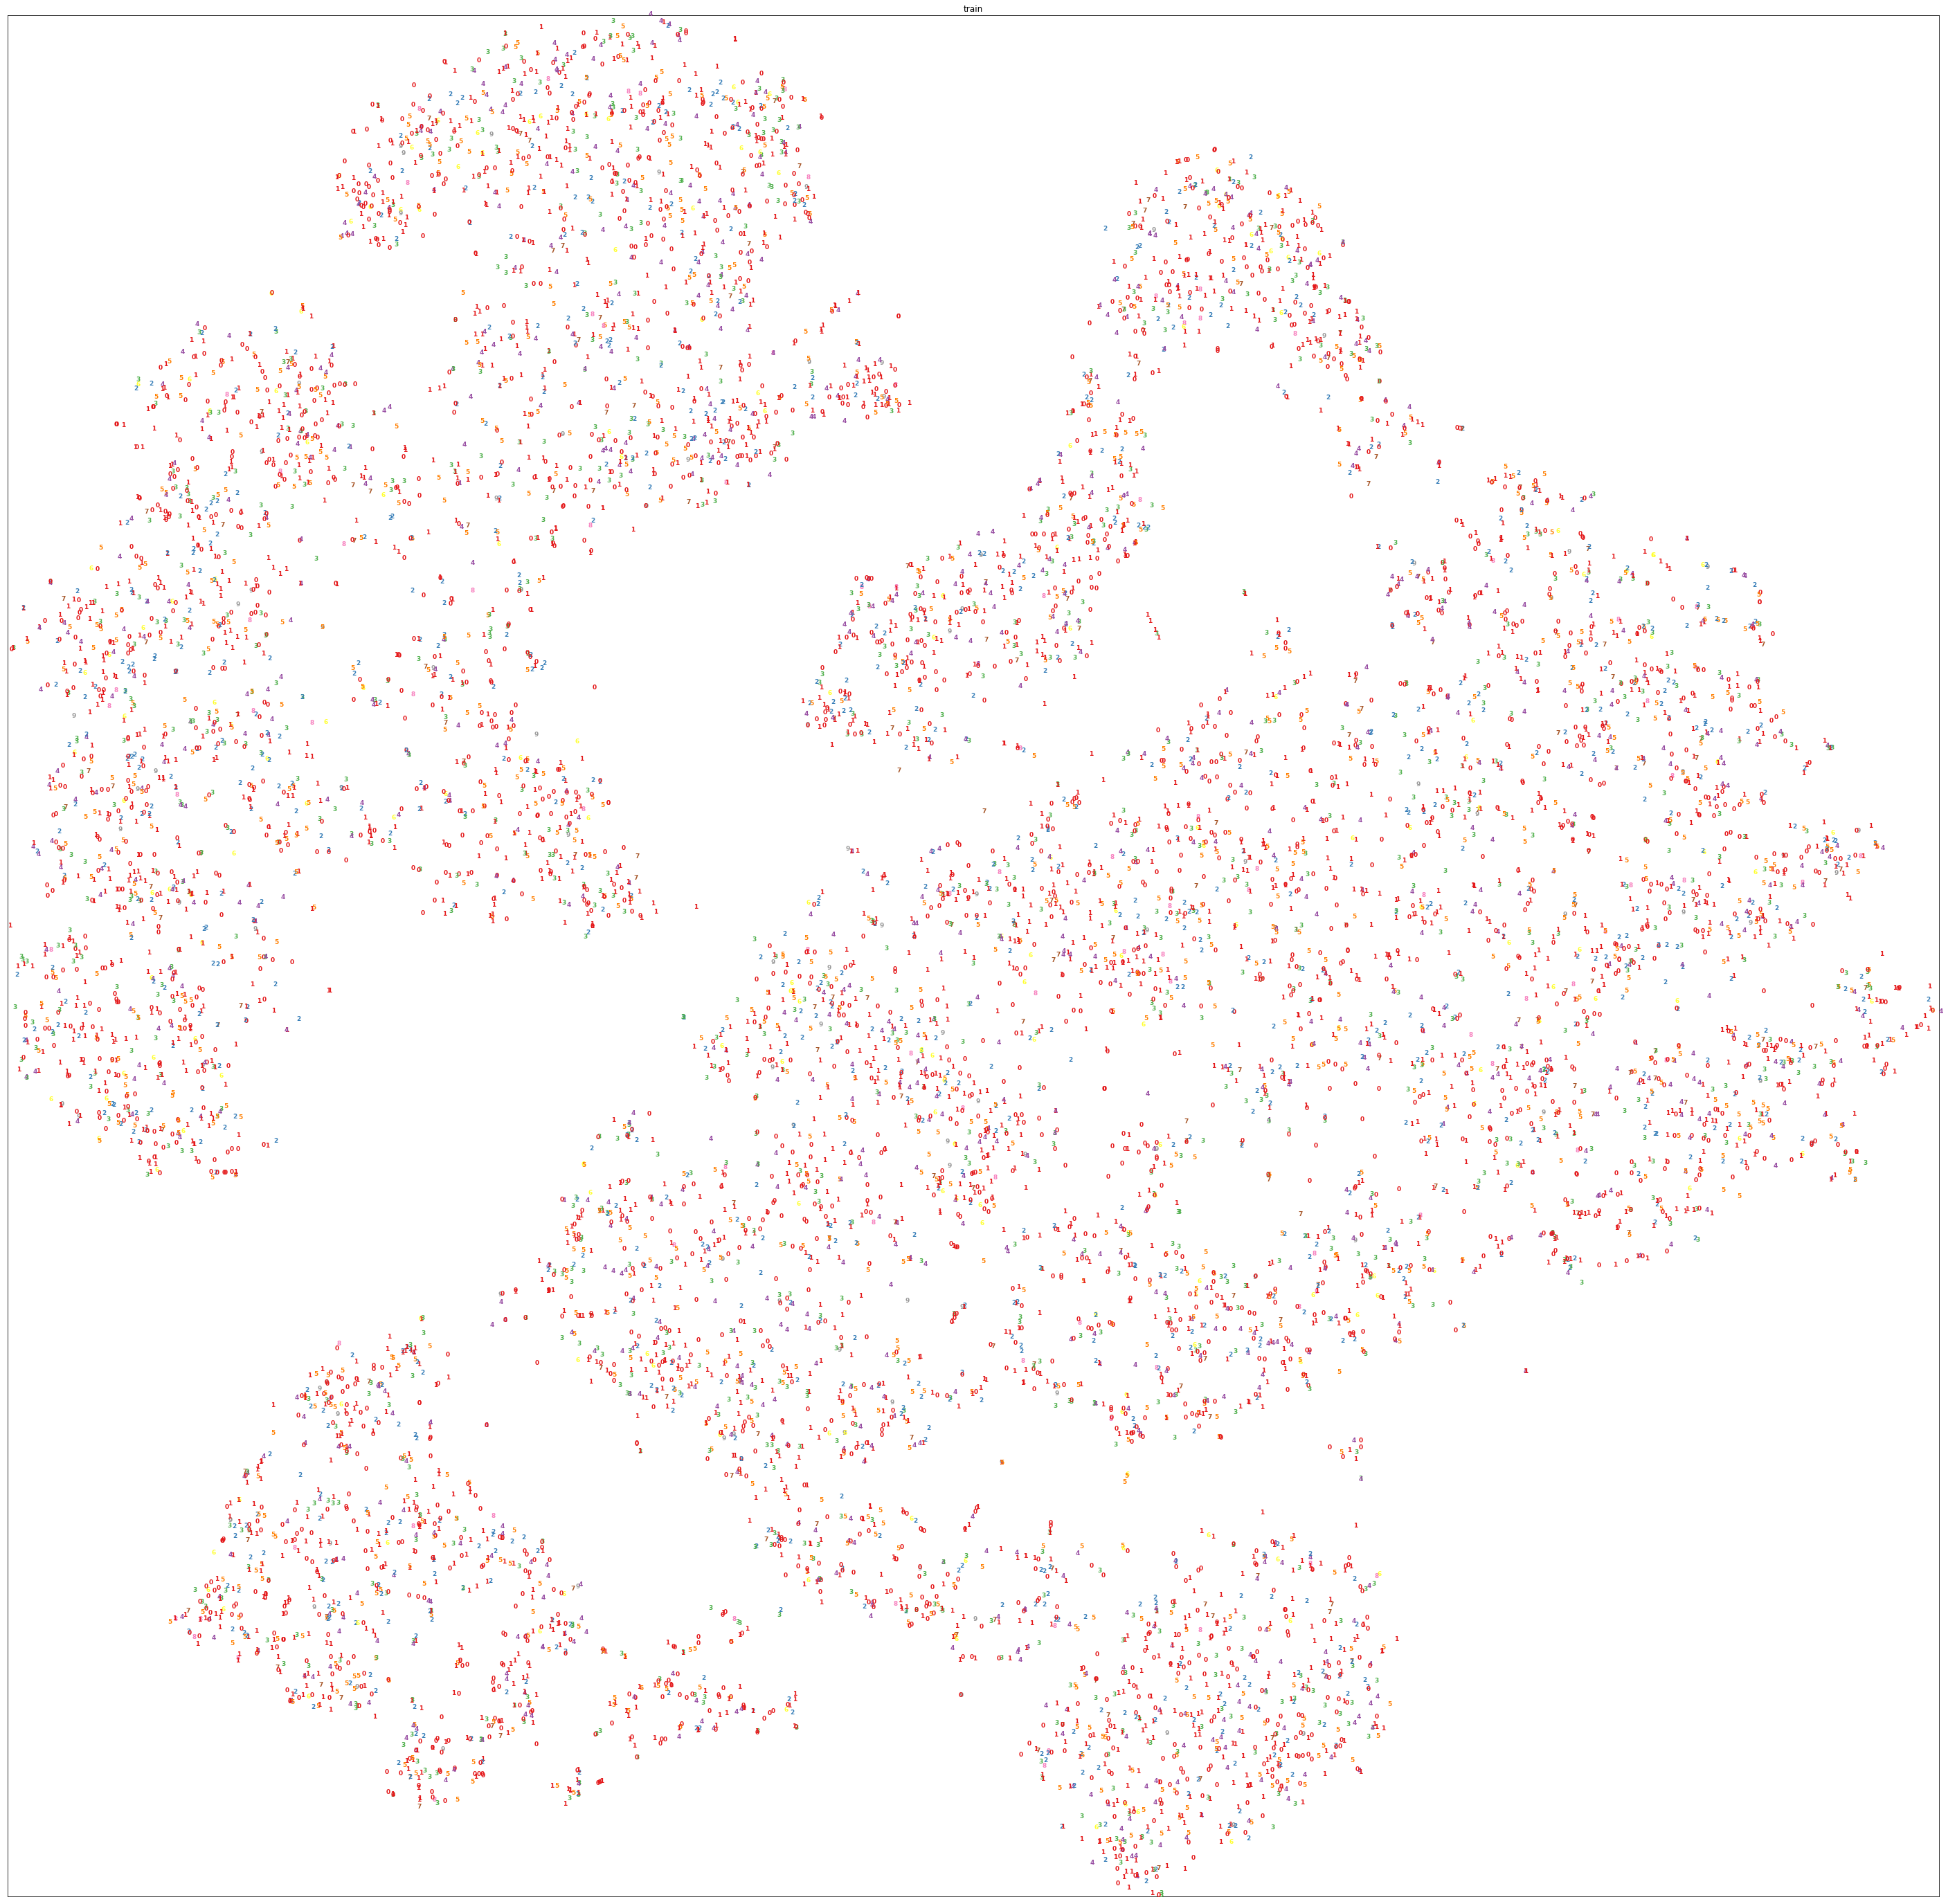

In [10]:
fig=plot(newXtr,y_train,"train")
fig.show()
fig=plot(newXte,y_train,"train")
fig.show()

## 4. Conclusion (5 points)

1.没有进行过shuffle的数据集，在三种方法knn，softmax，neutral network下的预测概率分别为 0.78，0.76，0.71
经过shuffle后，在三种方法knn，softmax，neutral network下的预测概率分别为 0.78， 0.76， 0.69
可见神经网络的训练跟数据的结构排布也有一定的关系

2.在所有方法中打出不同标签的预测正确个数，标签为 0，1，5这三种的预测概率较为准确，能达到90%及以上。标签为6的预测正确率只有可怜的10%左右。
而且训练效果knn要大于softmax要大于neutral network

3.通过tsne算法将高维特征可视化，观察训练集的分布特点，我们发现标签为 0，1，5的数据点紧紧团簇在各自的一小片区域，而数据点6则散漫的分布空间的各处，因此模型更容易学到标签为0，1的种类的特征，而很难学到标签6的特征

4.并且因为数据点是团簇分布的，对于knn通过测试集邻近的训练集数据的种类来判断相应的种类明显会更有优势，而对于神经网络而言，散漫分布的标签6数据点，和相互交错的标签2，4数据点，使得神经网络在学习的过程中存在很多的干扰，很难学到有用的一些特征。

## Reference
List your references here.

[1] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv: https://arxiv.org/abs/1708.07747, GitHub: https://github.com/zalandoresearch/fashion-mnist